---

# Detecting Credit Card Fraud with DBSCAN

In this notebook, we will use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to identify potential anomalies in credit card transactions, using the Credit Card Fraud Detection dataset. DBSCAN is an unsupervised clustering algorithm that groups together points that are closely packed in space (high density) and labels as noise any points that lie alone in low-density regions. This makes it especially well-suited for anomaly detection, where rare or irregular observations often exist outside of dense clusters.

Unlike algorithms such as K-Means, DBSCAN does not require specifying the number of clusters in advance. Instead, it relies on two parameters:

- eps, the maximum distance between two points to be considered neighbors

- min_samples, the minimum number of points required to form a dense region

In the context of fraud detection, the majority of transactions form dense, homogeneous clusters, while fraudulent transactions tend to be sparse and atypical. This imbalance makes fraud detection a natural application for DBSCAN, which can identify fraud cases as noise without using any labels during clustering.

The dataset we will use contains anonymized features derived from PCA transformations of credit card transaction data, including a binary label indicating whether each transaction is fraudulent. We will reduce the data to 2D using PCA for visualization, run DBSCAN on the projected data, and assess how well it separates out anomalies using the known labels (for evaluation purposes only).

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix

# For visualizations
import matplotlib.cm as cm

---

Download the data from the kaggle API.

---

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\kylej\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


---

Read the data into a dataframe.

---

In [3]:
df = pd.read_csv("creditcard.csv")

# Preview class distribution
print(df["Class"].value_counts())  # 0 = legit, 1 = fraud

df

Class
0    284315
1       492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


---

Define our features and targets. We now perform PCA (look at the PCA notebook for more detail) in order to reduce the dimensionality of the dataset to account for the most important features and make visualization and distance calculations easier.

---

In [4]:
# Separate features and labels
X = df.drop(columns="Class")
y = df["Class"]

# Scale features (PCA and DBSCAN both require it)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Combine for easier plotting later
df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["TrueLabel"] = y.values

df_plot

,PC1,PC2,TrueLabel
0,0.416630,-2.532664,0
1,-0.393453,-2.077326,0
2,1.868525,-2.533497,0
3,0.315744,-1.783506,0
4,-0.004379,-1.488415,0
...,...,...,...
284802,-1.493200,1.900149,0
284803,-0.366836,0.842366,0
284804,-0.194063,2.070788,0
284805,-0.466089,1.225394,0


---

We can now cluster using DBSCAN! We will label our clusters and compare them against their actual labels. We will treat all noise as predicted fraud and any clustered point as legitimate. We will run our first test using a smaller sample (to avoid memory issues) and with an epsilon of 1, which is a relatively large distance.

---

Classification Report (Treating DBSCAN Noise as Fraud):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34942
           1       0.00      0.00      0.00        58

    accuracy                           1.00     35000
   macro avg       0.50      0.50      0.50     35000
weighted avg       1.00      1.00      1.00     35000



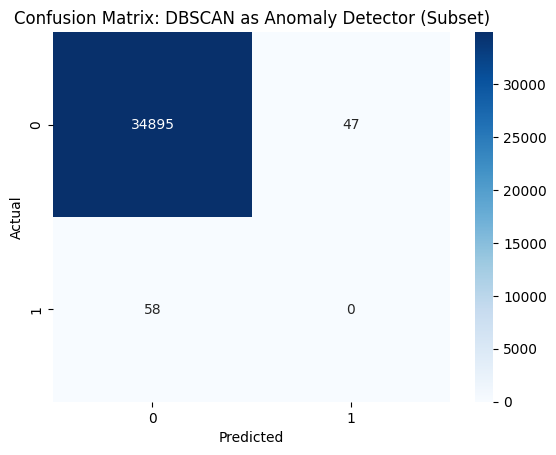

In [ ]:
df_small = df_plot.sample(n=35000, random_state=42)
X_small = df_small[['PC1', 'PC2']].values

dbscan = DBSCAN(eps=1, min_samples=5)
clusters = dbscan.fit_predict(X_small)

# Add cluster labels
df_small["Cluster"] = clusters
df_small

# Get the true labels for the same sampled points
y_small = df.loc[df_small.index, 'Class']

# Treat noise points as "predicted frauds" (anomalies)
predicted_fraud = (df_small["Cluster"] == -1).astype(int)

# Evaluate DBSCAN predictions against matching ground truth
print("Classification Report (Treating DBSCAN Noise as Fraud):")
print(classification_report(y_small, predicted_fraud))

sns.heatmap(confusion_matrix(y_small, predicted_fraud), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: DBSCAN as Anomaly Detector (Subset)")
plt.show()

---

Our model seems to be struggling, so we can visualize the clusters thanks to PCA:

---

C:\Users\kylej\AppData\Local\Temp\ipykernel_23500\3286784753.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab10')


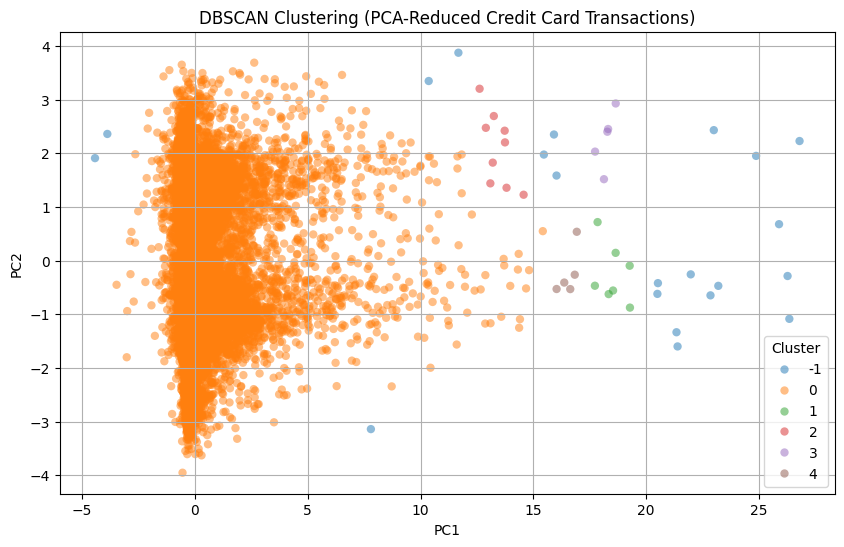

In [47]:
# DBSCAN assigns -1 to noise
plt.figure(figsize=(10, 6))
palette = cm.get_cmap('tab10')

sns.scatterplot(
    x="PC1", y="PC2", hue="Cluster", data=df_small,
    palette="tab10", alpha=0.5, legend='full', linewidth=0
)
plt.title("DBSCAN Clustering (PCA-Reduced Credit Card Transactions)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

---

Let's try a different epsilon value and see what happens. This one is much lower, meaning that the system is likely to identify more noise.

---

Classification Report (Treating DBSCAN Noise as Fraud):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     34942
           1       0.01      0.19      0.02        58

    accuracy                           0.97     35000
   macro avg       0.50      0.58      0.50     35000
weighted avg       1.00      0.97      0.98     35000



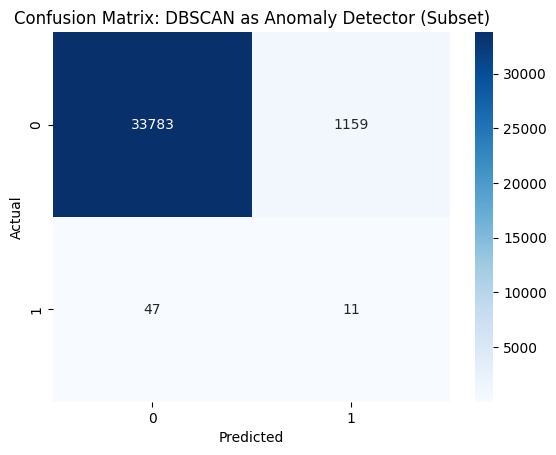

C:\Users\kylej\AppData\Local\Temp\ipykernel_23500\3907879769.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab10')


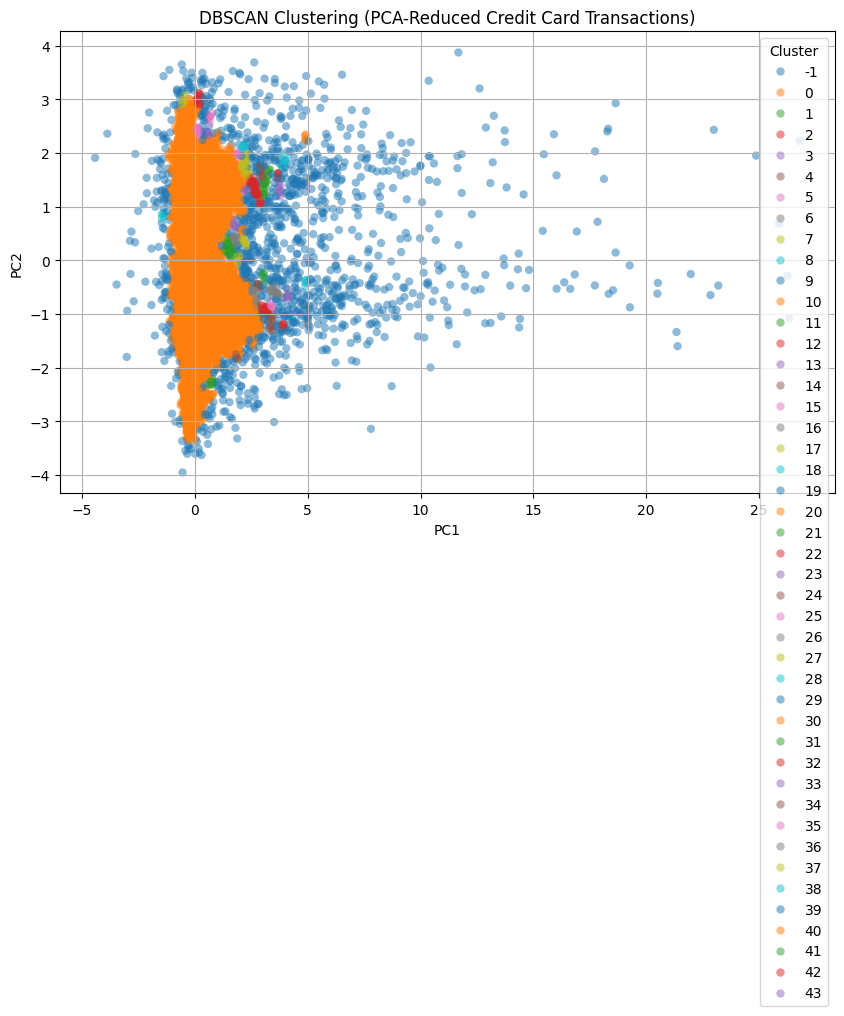

In [50]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
clusters = dbscan.fit_predict(X_small)

# Add cluster labels
df_small["Cluster"] = clusters
df_small

# Get the true labels for the same sampled points
y_small = df.loc[df_small.index, 'Class']

# Treat noise points as "predicted frauds" (anomalies)
predicted_fraud = (df_small["Cluster"] == -1).astype(int)

# Evaluate DBSCAN predictions against matching ground truth
print("Classification Report (Treating DBSCAN Noise as Fraud):")
print(classification_report(y_small, predicted_fraud))

sns.heatmap(confusion_matrix(y_small, predicted_fraud), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: DBSCAN as Anomaly Detector (Subset)")
plt.show()

# DBSCAN assigns -1 to noise
plt.figure(figsize=(10, 6))
palette = cm.get_cmap('tab10')

sns.scatterplot(
    x="PC1", y="PC2", hue="Cluster", data=df_small,
    palette="tab10", alpha=0.5, legend='full', linewidth=0
)
plt.title("DBSCAN Clustering (PCA-Reduced Credit Card Transactions)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

---

This model was misidentified more legitimate activity as fraudulent, but was also able to catch some fraud too. Visually inspecting the graph, it looks like our epsilon is a bit too small, so let's increase it a bit.

---

Classification Report (Treating DBSCAN Noise as Fraud):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34942
           1       0.00      0.00      0.00        58

    accuracy                           1.00     35000
   macro avg       0.50      0.50      0.50     35000
weighted avg       1.00      1.00      1.00     35000



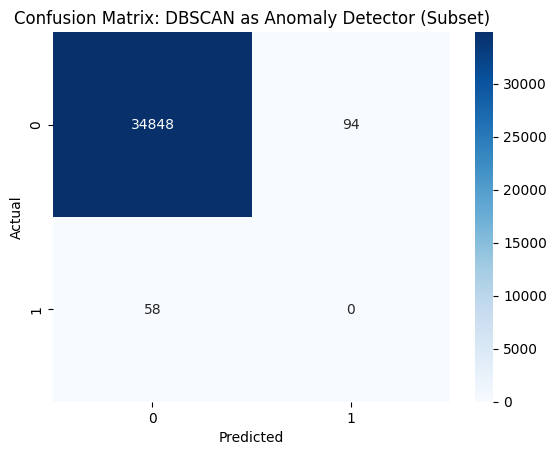

C:\Users\kylej\AppData\Local\Temp\ipykernel_23500\765088835.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab10')


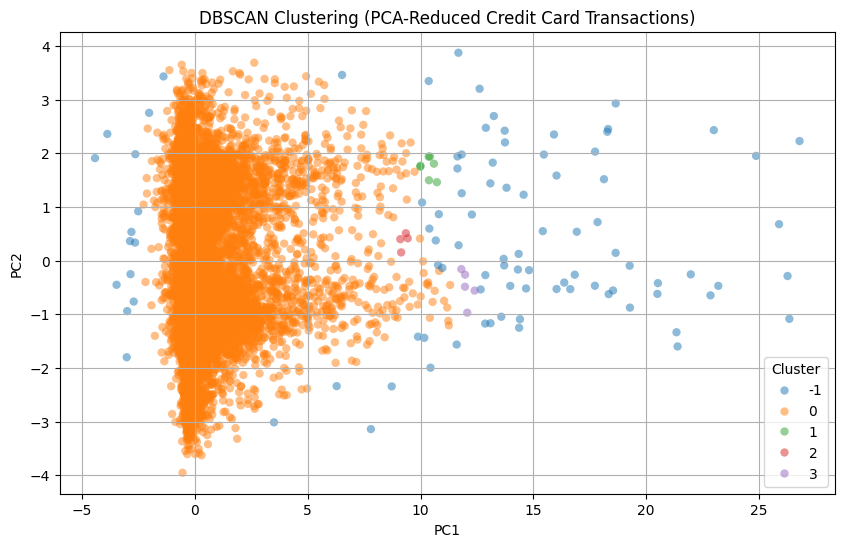

In [51]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_small)

# Add cluster labels
df_small["Cluster"] = clusters
df_small

# Get the true labels for the same sampled points
y_small = df.loc[df_small.index, 'Class']

# Treat noise points as "predicted frauds" (anomalies)
predicted_fraud = (df_small["Cluster"] == -1).astype(int)

# Evaluate DBSCAN predictions against matching ground truth
print("Classification Report (Treating DBSCAN Noise as Fraud):")
print(classification_report(y_small, predicted_fraud))

sns.heatmap(confusion_matrix(y_small, predicted_fraud), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: DBSCAN as Anomaly Detector (Subset)")
plt.show()

# DBSCAN assigns -1 to noise
plt.figure(figsize=(10, 6))
palette = cm.get_cmap('tab10')

sns.scatterplot(
    x="PC1", y="PC2", hue="Cluster", data=df_small,
    palette="tab10", alpha=0.5, legend='full', linewidth=0
)
plt.title("DBSCAN Clustering (PCA-Reduced Credit Card Transactions)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

---

These clusters visually appear better, but the model is still failing to find actual cases of fraud. We can alter the min_samples parameter and see how the clusters look after:

---

Classification Report (Treating DBSCAN Noise as Fraud):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     34942
           1       0.01      0.26      0.01        58

    accuracy                           0.93     35000
   macro avg       0.50      0.60      0.49     35000
weighted avg       1.00      0.93      0.96     35000



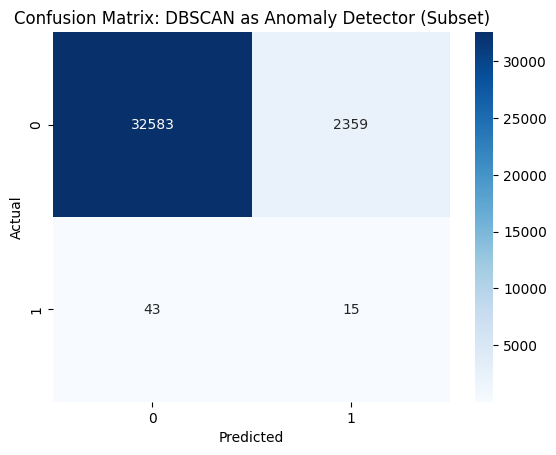

C:\Users\kylej\AppData\Local\Temp\ipykernel_23500\3920055278.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab10')


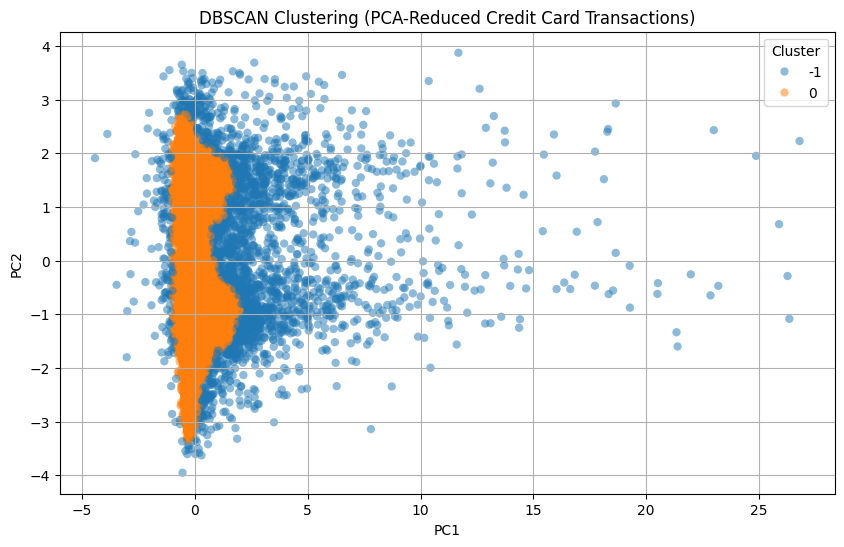

In [58]:
dbscan = DBSCAN(eps=0.2, min_samples=60)
clusters = dbscan.fit_predict(X_small)

# Add cluster labels
df_small["Cluster"] = clusters
df_small

# Get the true labels for the same sampled points
y_small = df.loc[df_small.index, 'Class']

# Treat noise points as "predicted frauds" (anomalies)
predicted_fraud = (df_small["Cluster"] == -1).astype(int)

# Evaluate DBSCAN predictions against matching ground truth
print("Classification Report (Treating DBSCAN Noise as Fraud):")
print(classification_report(y_small, predicted_fraud))

sns.heatmap(confusion_matrix(y_small, predicted_fraud), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: DBSCAN as Anomaly Detector (Subset)")
plt.show()

# DBSCAN assigns -1 to noise
plt.figure(figsize=(10, 6))
palette = cm.get_cmap('tab10')

sns.scatterplot(
    x="PC1", y="PC2", hue="Cluster", data=df_small,
    palette="tab10", alpha=0.5, legend='full', linewidth=0
)
plt.title("DBSCAN Clustering (PCA-Reduced Credit Card Transactions)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

---

As we can see, playing with the parameters can get us closer to identifying the majority of fraudulent charges at the risk of flagging too many false positives. In a real-world application, different pre-processing measures may be taken in order to reduce the likelihood of possible fraudulent charges. Perhaps a different distance function could also be useful, since the shape of the data is not exactly ball-like. Regardless, we can see how powerful DBSCAN is as an unsupervised algorithm for processing large amounts of data and grouping them into clusters!

---